# Purpose

Determine sucess of pricing test on website

Should the company sell the softeware for 39 or 59

What happened to conversion rate

Should the test be run for a smaller period of time

# Solution

Conversion rate suffers from price change by ~ 25% in each cohort (each month)

However Revenue goes from 0.02 x 39 = 0.78 dollars / visit --> 0.015 x 59 = 0.885 dollars / visit
On average I gain 10 cents per visit by switching to 59 dollar pricing

Moreover at the end of cohort in may ( the last 5 days ) the conversion rate of the 1 group dramatically increases and is relatively similar to that of the 0 group indicating that people are willing to pay more for the product by end of may.

Conversion rate seems tto increase with web users while it decreases with mobile users, regardles of price

Conversion rate and price is very much tied to the Source

    - SEO yahoo and SEO other picks up considerably over the course of the test for the higher price
    - ads- other also saw significant increase in conversion rate for higher pricing by month 3
    - it appears that it took roughly 3 months for SEO to begin working again
    - bing users hate the increase in price and conversion drop off significantly
    
### Should the test ended earlier?

By the first month the revenue had already increased by 10 cents per customer and the experiemtn could have ended there.

However, it took at least 3 months for the SEO data to show any relevant trends

### future ideas

Total visits should also be considered as it will inform the company if they are losing too much traffic
location and operating system can also be considered.

hypothesis tests should be conducted on cohort analysis most likely using chi-square test on equality of porportions

cohort analysis can be done on finer scale (e.g. weeks instead of months)

# Analysis

In [189]:
# import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# create input and output file paths
input_path = '../data/input/'
user_path = input_path + 'user_table.csv'
test_results_path = input_path + 'test_results.csv'

working_path = '../data/working/{}.csv'.format(datetime.today())

output_path = '../data/output/{}.csv'.format(datetime.today())

## Load and Clean Data

In [87]:
users = pd.read_csv(user_path)
tr = pd.read_csv(test_results_path, parse_dates = ['timestamp'])

In [88]:
users.info()
users.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null object
country    275616 non-null object
lat        275616 non-null float64
long       275616 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


(275616, 5)

In [89]:
tr.info()
tr.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


(316800, 8)

In [97]:
# timestamp is messed up and conversion is trickey there about 10,000/300,000 nat values when coerced
# but this only affects the times, so we can convert and ignore this
tr['timestamp'].iloc[316771]
tr['timestamp_conv'] = pd.to_datetime(tr['timestamp'], format = '%y-%m-%d', exact = False)
tr.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,timestamp_conv
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015-05-08
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015-05-10
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015-04-04
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015-05-07
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015-05-24


In [98]:
# No duplicates
print(users.drop_duplicates().shape,tr.drop_duplicates().shape)

(275616, 5) (316800, 9)


## Explore Data

Did users see the test multiple times

In [60]:
# No multiple users
multiple = (tr['user_id'].value_counts() > 1)
multiple.value_counts()

False    316800
Name: user_id, dtype: int64

In [64]:
# range of data is march 2, 2015 to april 31, 2015 (only 3 months so lets cohort by week)
print(tr['timestamp'].min(),tr['timestamp'].max())

2015-03-02 00:04:12 2015-05-31 23:59:45


In [158]:
# create cohorts by month
tr['time_period'] = tr['timestamp_conv'].apply(lambda x: x.strftime('%m-%d'))
tr['cohort_group'] = tr['timestamp_conv'].apply(lambda x: x.strftime('%m'))
tr.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,timestamp_conv,time_period,cohort_group
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015-05-08,05-08,05
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015-05-10,05-10,05
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015-04-04,04-04,04
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015-05-07,05-07,05
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015-05-24,05-24,05


In [164]:
# create cohorts
def create_cohort(g_by = ['cohort_group', 'time_period', 'test']):
    grouped = tr.sort_values(by = ['time_period'])
    grouped = grouped.groupby(g_by)
    cohorts = grouped.aggregate({'user_id' : pd.Series.nunique, 'converted' : pd.Series.sum})
    cohorts = cohorts.rename(columns = {'user_id':'total_users', 'converted':'total_converted'})
    cohorts['conversion_rate'] = cohorts['total_converted']/cohorts['total_users'] * 100
    return cohorts

cohorts = create_cohort()
cohorts.head()

total_users  total_converted  conversion_rate
cohort_group time_period test                                               
03           03-02       0            1011               18         1.780415
                         1             578                9         1.557093
             03-03       0             918               21         2.287582
                         1             578                6         1.038062
             03-04       0             952               28         2.941176

In [165]:
cohorts['conversion_rate'] = cohorts['total_converted']/cohorts['total_users'] * 100
cohorts.head()

total_users  total_converted  conversion_rate
cohort_group time_period test                                               
03           03-02       0            1011               18         1.780415
                         1             578                9         1.557093
             03-03       0             918               21         2.287582
                         1             578                6         1.038062
             03-04       0             952               28         2.941176

In [151]:
unpacked = cohorts['conversion_rate'].unstack(0)
unpacked = unpacked.unstack(1)
unpacked.head()

cohort_group        03            04      05    
test                 0         1   0   1   0   1
time_period                                     
03-02         1.780415  1.557093 NaN NaN NaN NaN
03-03         2.287582  1.038062 NaN NaN NaN NaN
03-04         2.941176  1.301518 NaN NaN NaN NaN
03-05         2.593010  2.292264 NaN NaN NaN NaN
03-06         1.844618  1.650038 NaN NaN NaN NaN

Text(0,0.5,'Conversion Rate')

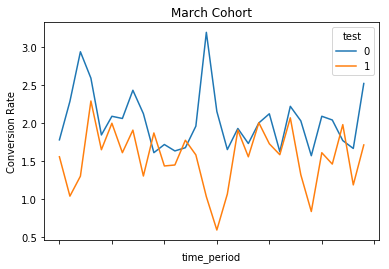

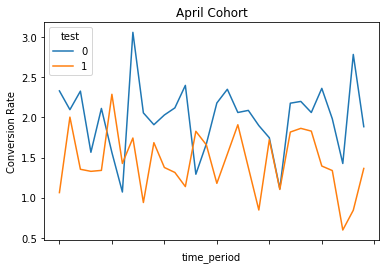

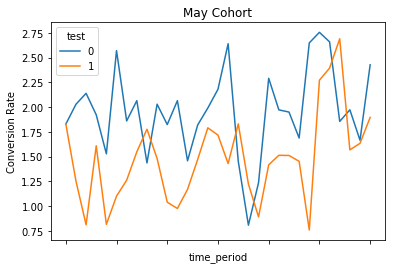

In [191]:
unpacked['03'].plot()
plt.title('March Cohort')
plt.ylabel('Conversion Rate')
unpacked['04'].plot()
plt.title('April Cohort')
plt.ylabel('Conversion Rate')
unpacked['05'].plot()
plt.title('May Cohort')
plt.ylabel('Conversion Rate')

In [161]:
unpacked.mean()

cohort_group  test
03            0       2.036480
              1       1.547459
04            0       1.995415
              1       1.440004
05            0       1.961063
              1       1.488903
dtype: float64

## look at device, source and OS information

In [186]:
device = create_cohort(g_by = ['cohort_group', 'test','device'])
device = device['conversion_rate'].unstack(2)
device = device.unstack(1)

device.head()

device          mobile                 web          
test                 0         1         0         1
cohort_group                                        
03            2.002263  1.722425  1.899624  1.476931
04            2.064814  1.585945  2.022176  1.380388
05            1.906121  1.542211  2.053206  1.549676

### device cohort analysis

Text(0,0.5,'Conversion Rate')

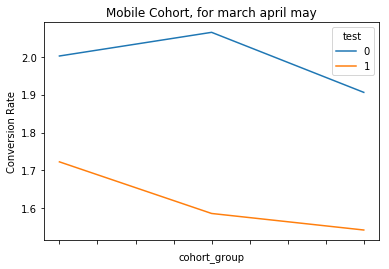

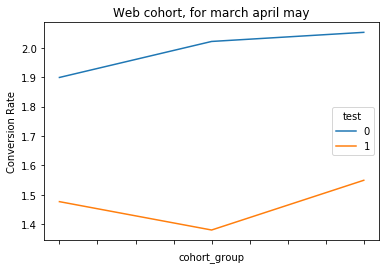

In [228]:
device['mobile'].plot()
plt.title('Mobile Cohort, for march april may')
plt.ylabel('Conversion Rate')
device['web'].plot()
plt.title('Web cohort, for march april may')
plt.ylabel('Conversion Rate')

In [200]:
## analyze by source
source = create_cohort(g_by = ['cohort_group', 'test','source'])
source = source['conversion_rate'].unstack(0)
source = source.unstack(0)

source.head()

cohort_group        03                  04                  05          
test                 0         1         0         1         0         1
source                                                                  
ads-bing      1.336254  1.236882  1.297596  0.828729  1.366274  0.816460
ads-google    2.347884  2.090338  2.166385  1.869978  2.254513  1.928727
ads-yahoo     1.801242  1.193059  1.440200  1.173709  1.800124  1.009082
ads_facebook  2.033898  1.737452  2.516838  1.597289  2.517425  1.714369
ads_other     1.481843  1.263962  1.908646  1.115678  1.269072  1.347780

### Source cohort analysis

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

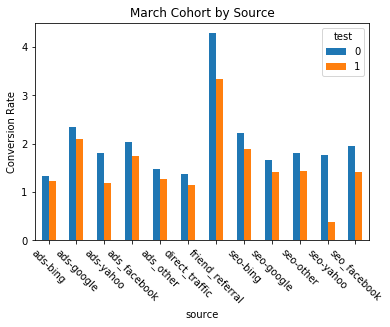

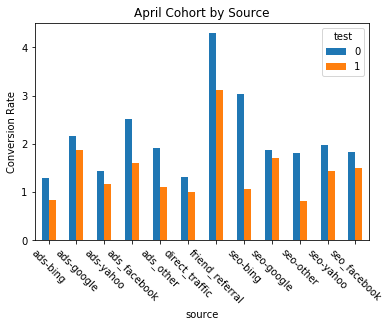

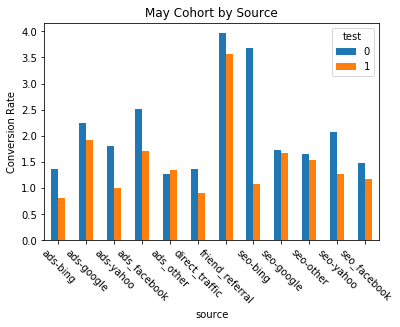

In [209]:
source['03'].plot(kind = 'bar')
plt.title('March Cohort by Source')
plt.ylabel('Conversion Rate')
plt.xticks(rotation = -45)
source['04'].plot(kind = 'bar')
plt.title('April Cohort by Source')
plt.ylabel('Conversion Rate')
plt.xticks(rotation = -45)
source['05'].plot(kind = 'bar')
plt.title('May Cohort by Source')
plt.ylabel('Conversion Rate')
plt.xticks(rotation = -45)

In [214]:
source1 = create_cohort(g_by = ['cohort_group', 'test','source'])
source1 = source1['conversion_rate'].unstack(2)
source1 = source1.unstack(1)

source1.head()

source        ads-bing           ads-google           ads-yahoo            \
test                 0         1          0         1         0         1   
cohort_group                                                                
03            1.336254  1.236882   2.347884  2.090338  1.801242  1.193059   
04            1.297596  0.828729   2.166385  1.869978  1.440200  1.173709   
05            1.366274  0.816460   2.254513  1.928727  1.800124  1.009082   

source       ads_facebook           ads_other              ...     seo-bing  \
test                    0         1         0         1    ...            0   
cohort_group                                               ...                
03               2.033898  1.737452  1.481843  1.263962    ...     2.232143   
04               2.516838  1.597289  1.908646  1.115678    ...     3.022670   
05               2.517425  1.714369  1.269072  1.347780    ...     3.680982   

source                 seo-google           seo-other           seo-yahoo  \
test                 1          0         1         0         1         0   
cohort_group                                                                
03            1.901141   1.665599  1.405701  1.804265  1.425856  1.776830   
04            1.071429   1.869159  1.708075  1.813333  0.822368  1.985294   
05            1.086957   1.728215  1.668937  1.647597  1.541251  2.067669   

source                 seo_facebook            
test                 1            0         1  
cohort_group                                   
03            0.389610     1.957547  1.425577  
04            1.428571     1.830664  1.509134  
05            1.269841     1.481177  1.165666  

[3 rows x 24 columns]

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

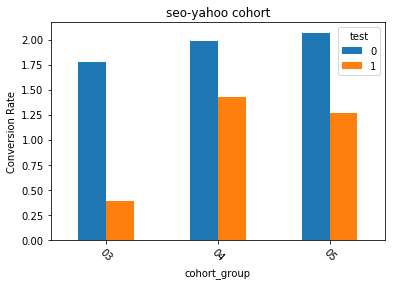

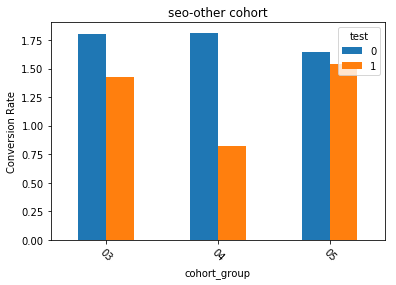

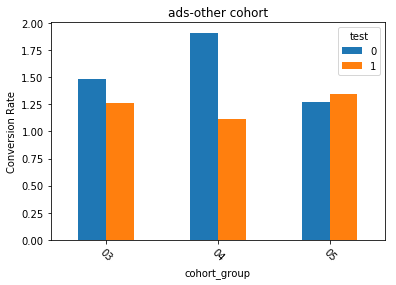

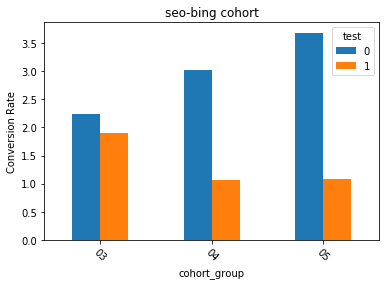

In [231]:
source1['seo-yahoo'].plot(kind = 'bar')
plt.title('seo-yahoo cohort')
plt.ylabel('Conversion Rate')
plt.xticks(rotation = -45)
source1['seo-other'].plot(kind = 'bar')
plt.title('seo-other cohort')
plt.ylabel('Conversion Rate')
plt.xticks(rotation = -45)
source1['ads_other'].plot(kind = 'bar')
plt.title('ads-other cohort')
plt.ylabel('Conversion Rate')
plt.xticks(rotation = -45)
source1['seo-bing'].plot(kind = 'bar')
plt.title('seo-bing cohort')
plt.ylabel('Conversion Rate')
plt.xticks(rotation = -45)

# Solution

Conversion rate suffers from price change by ~ 25% in each cohort (each month)

However Revenue goes from 0.02 x 39 = 0.78 dollars / visit --> 0.015 x 59 = 0.885 dollars / visit
On average I gain 10 cents per visit by switching to 59 dollar pricing

Moreover at the end of cohort in may ( the last 5 days ) the conversion rate of the 1 group dramatically increases and is relatively similar to that of the 0 group indicating that people are willing to pay more for the product by end of may.

Conversion rate seems tto increase with web users while it decreases with mobile users, regardles of price

Conversion rate and price is very much tied to the Source

    - SEO yahoo and SEO other picks up considerably over the course of the test for the higher price
    - ads- other also saw significant increase in conversion rate for higher pricing by month 3
    - it appears that it took roughly 3 months for SEO to begin working again
    - bing users hate the increase in price and conversion drop off significantly
    
### Should the test ended earlier?

By the first month the revenue had already increased by 10 cents per customer and the experiemtn could have ended there.

However, it took at least 3 months for the SEO data to show any relevant trends

### future ideas

Total visits should also be considered as it will inform the company if they are losing too much traffic
location and operating system can also be considered.

hypothesis tests should be conducted on cohort analysis most likely using chi-square test on equality of porportions

cohort analysis can be done on finer scale (e.g. weeks instead of months)